# GRU for text classification  

In this notebook, we will tackle the "Natural Language Processing with Disaster Tweets" competition, hosted on Kaggle. The objective of this competition is to classify tweets that refer to real disasters and distinguish them from tweets that are unrelated to such events. This is a binary classification problem, where the target variable indicates whether a tweet is about a disaster (1) or not (0).

Tweets often contain unstructured text, abbreviations, and noisy data, which makes Natural Language Processing (NLP) an ideal field to handle such challenges. In this notebook, we will build and train a Gated Recurrent Unit (GRU) model, a type of recurrent neural network (RNN), to predict whether a given tweet is related to a real disaste.  

## The primary goals of this notebook are:

* Data Preprocessing: Prepare the tweet data for input into the model by cleaning, tokenizing, and padding the text.  
* Feature Engineering: Convert the textual data into numeric representations using embeddings that the GRU model can process.  
* Model Building: Design a neural network architecture that leverages a GRU layer to capture the temporal structure of the text.  
* Model Training and Evaluation: Train the model on the training data, evaluate its performance on validation data, and optimize the model using techniques like early stopping and learning rate reduction.  
* Prediction and Submission: Generate predictions on the test data and submit them for evaluation in the competition.

##  Importing libraries

In [46]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import re
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from nltk.stem import PorterStemmer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Embedding, LSTM, GRU, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


## Exploring data  
The dataset consists of two files:
- train.csv
- test.csv
Let's have a look at their content.

In [2]:
train = pd.read_csv(os.path.join(dirname, 'train.csv'))
test = pd.read_csv(os.path.join(dirname, 'test.csv'))
print(f"Number of rows: {train.shape[0]}")
train.head()

Number of rows: 7613


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [8]:
test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [3]:
train.apply(lambda x: x.isna().sum())

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

Text(0.5, 1.0, 'target categories count')

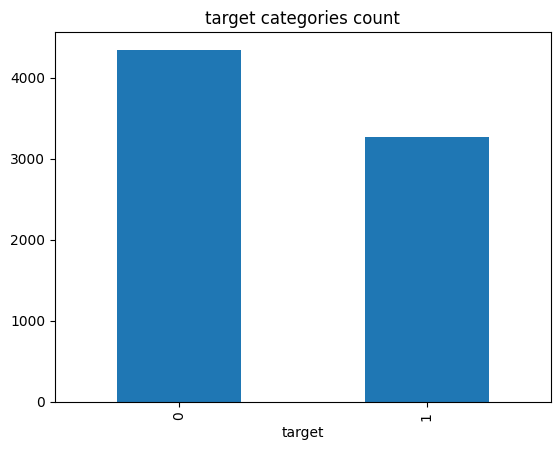

In [4]:
train['target'].value_counts().plot(kind='bar')
plt.title('target categories count')

Text(0.5, 1.0, 'lenght of text distribution')

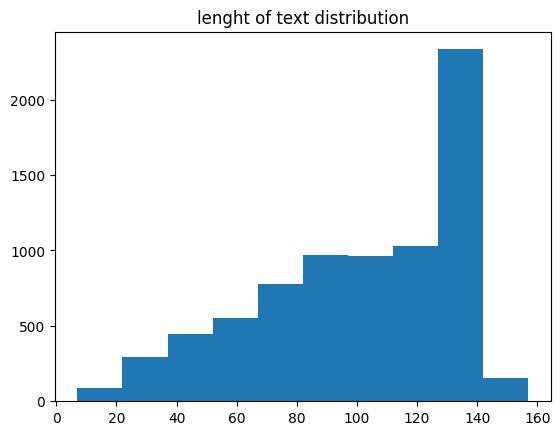

In [5]:
plt.hist([len(x) for x in train['text']])
plt.title('lenght of text distribution')

## Preprocessing
Preprocessing steps: 
1. Text Cleaning  
Remove URLs, numbers, punctuation, special characters.  
2. Stemming  
Reduce words to their root or base form, known as a stem. For example, "running," "runner," and "ran" would all be reduced to "run." This helps reduce vocabulary size and normalize words that share the same meaning.
3. Tokenization  
Convert each word in the tweet into a token (a unique integer).
Pad or truncate the sequences to ensure uniform length

In [13]:
def clean_text(text):
    # Convert text to lowercase
    text = text.lower()
    
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    # Remove special characters, numbers, and punctuation
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'#', '', text)
    text = re.sub(r'@', '', text)
    
    return text

In [11]:
stemmer = PorterStemmer()
def stem_text(text):
    return ' '.join([stemmer.stem(word) for word in text.split()])

In [16]:
stemmed_train_text = [stem_text(clean_text(t)) for t in train['text']]

In [116]:
vocab_size=10000
tokenizer = Tokenizer(num_words=vocab_size, oov_token='<OOV>')
tokenizer.fit_on_texts(stemmed_train_text)
tok_train_text = tokenizer.texts_to_sequences(stemmed_train_text)

In [172]:
max_length = 25
padded_train_text = pad_sequences(tok_train_text, maxlen = max_length, padding='post')

## Split training data in train and validation sets

In [173]:
train_X, val_X, train_y, val_y = train_test_split(padded_train_text, 
                                                  train['target'], 
                                                  test_size=0.2, 
                                                  random_state=33)

## Generate the model
The model is a Sequential neural network designed for binary text classification.  
 It uses a GRU (Gated Recurrent Unit) layer to capture sequential patterns in the text data:

Input Layer:  
This layer accepts sequences of integer tokens (each representing a word) of length max_length, which is the fixed length of each input sequence after padding.  

Embedding Layer:  
This layer transforms each word (represented by its integer index) into a dense vector of fixed size (32), which encodes semantic information about the words. The embedding layer maps each word in the sequence to a 32-dimensional vector.  

GRU Layer:  
The GRU layer processes the sequential data and captures long-term dependencies in the input text. It has 64 hidden units, meaning it outputs a 64-dimensional vector at each time step, summarizing the learned patterns from the sequence.

Dense Output Layer:    
The final layer is a fully connected (Dense) layer with a single output neuron. The sigmoid activation function is used here because the task is binary classification, producing an output probability between 0 and 1. The model will predict 1 (disaster tweet) if the output is close to 1 and 0 (non-disaster tweet) if the output is close to 0.  

Compilation:  
Optimizer: adam (Adaptive Moment Estimation) is used, which adjusts the learning rate during training to converge more efficiently.  
Loss Function: binary_crossentropy is appropriate for binary classification tasks where the output is either 0 or 1.  
Metrics: accuracy is used to evaluate how well the model is classifying tweets.  

In [220]:
embedding_dim = 32
model = Sequential()
model.add(Input(shape=(max_length,)))
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim))
#model.add(LSTM(64))
model.add(GRU(64))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_37"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_40 (Embedding)        │ (None, 25, 32)         │       320,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_8 (GRU)                     │ (None, 64)             │        18,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 338,881 (1.29 MB)

 Trainable params: 338,881 (1.29 MB)

 Non-trainable params: 0 (0.00 B)

## Training the model  
The following callbacks are applied to the fitting process:  
EarlyStopping: it prevents overfitting by stopping training when the model performance on the validation set no longer improves.  
ModelCheckpoint: it ensures that the best-performing model (based on validation loss) is saved during training.  
ReduceLROnPlateau: it adapts the learning rate when the model stops improving, giving the model more fine-grained adjustments as it converges to the optimal solution.

In [258]:
epochs = 50
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6)
model.fit(train_X,
          train_y,
          validation_data=(val_X, val_y),
          epochs=epochs,
          callbacks=[early_stopping,model_checkpoint, reduce_lr])

Epoch 1/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - accuracy: 0.8922 - loss: 0.2840 - val_accuracy: 0.7866 - val_loss: 0.5108 - learning_rate: 2.0000e-04
Epoch 2/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.9103 - loss: 0.2435 - val_accuracy: 0.7735 - val_loss: 0.5262 - learning_rate: 2.0000e-04
Epoch 3/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - accuracy: 0.9228 - loss: 0.2105 - val_accuracy: 0.7899 - val_loss: 0.5300 - learning_rate: 2.0000e-04
Epoch 4/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.9289 - loss: 0.2020 - val_accuracy: 0.7859 - val_loss: 0.5897 - learning_rate: 4.0000e-05


The best result in term of loss function on validation set is on Epoch 1:
Accuracy for training set is 0.8922, while the accuracy on the validation set is 0.7866.
The quite large difference in these values can suggest some overfitting issue. The model could benefit by some regularization

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


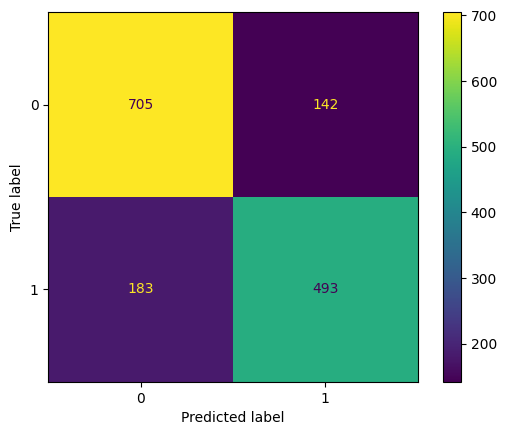

In [260]:
prediction = (model.predict(val_X)>0.5).astype('int32')
ConfusionMatrixDisplay.from_predictions(val_y, prediction)

## Prediction and submission  
The model is applied to the test dataset and the submission.csv file is generated.

In [261]:
stemmed_test_text = [stem_text(clean_text(t)) for t in test['text']]
tok_test_text = tokenizer.texts_to_sequences(stemmed_test_text)
padded_test_text = pad_sequences(tok_test_text, maxlen = max_length, padding='post')
prediction = (model.predict(padded_test_text)>0.5).astype('int32')
pd.DataFrame({'id': test['id'], 'target': prediction.flatten()}).to_csv('submission.csv', index=False)

102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


## Improving the model with some regularization

In [262]:
model2 = Sequential()
model2.add(Input(shape=(max_length,)))
model2.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim))
model2.add(GRU(64))
model2.add(Dropout(0.3))
model2.add(Dense(1, activation='sigmoid'))

model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model2.summary()

Model: "sequential_52"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_55 (Embedding)        │ (None, 25, 32)         │       320,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_30 (GRU)                    │ (None, 64)             │        18,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_51 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 338,881 (1.29 MB)

 Trainable params: 338,881 (1.29 MB)

 Non-trainable params: 0 (0.00 B)

In [269]:
model2.fit(train_X,
          train_y,
          validation_data=(val_X, val_y),
          epochs=epochs,
          callbacks=[early_stopping,model_checkpoint, reduce_lr])

Epoch 1/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.9397 - loss: 0.1696 - val_accuracy: 0.7754 - val_loss: 0.5984 - learning_rate: 1.0000e-06
Epoch 2/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.9357 - loss: 0.1850 - val_accuracy: 0.7748 - val_loss: 0.5986 - learning_rate: 1.0000e-06
Epoch 3/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.9435 - loss: 0.1689 - val_accuracy: 0.7748 - val_loss: 0.5991 - learning_rate: 1.0000e-06


The results from the second model look very similar to the previous one.  
We prepare anyway for the submission.

In [270]:
prediction = (model2.predict(padded_test_text)>0.5).astype('int32')
pd.DataFrame({'id': test['id'], 'target': prediction.flatten()}).to_csv('submission2.csv', index=False)

102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


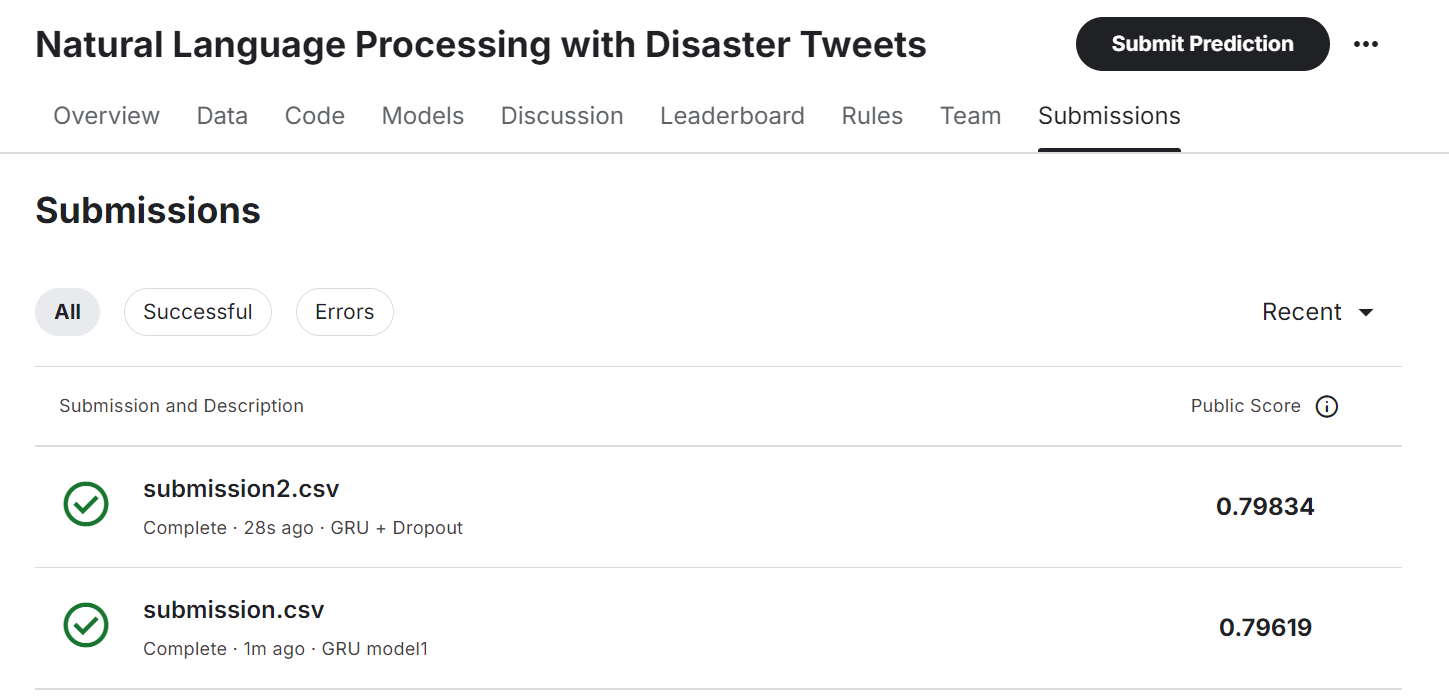